In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import matplotlib.style
import matplotlib.ticker as ticker


# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
pers_experiments = "(hostname == 'scyper21' or hostname == 'scyper22')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton.1", "sortledton", "stinger7-ref", "teseo-lcc.12"]
#libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "sortledton", "teseo-lcc.12", "llama8-ref"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

threads_filter = [1, 2, 4, 8, 14, 28, 42, 56]
threads_filter = " | ".join(map(lambda l: "num_threads == " + str(l), threads_filter))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

scaling_graphs="graph == 'graph500-24'"

data = common.import_gfe("View_Inserts").query(pers_experiments).copy() # data from the experiments
data = data.query(scaling_graphs)
data = data.query(threads_filter)
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]
data = data.query(libraries_filter)

data = data.merge(data.query("num_threads == 1"), on=["compiler", "graph", "library"], suffixes=("", "_y"), how="outer")
data["base_time"] = data["edges_per_second_y"]
data["speedup"] = data["edges_per_second"] / data["base_time"]

In [3]:
data_grouped = data.groupby(["compiler_family", "graph", "library", "build_frequency", "num_threads"]) \
    .agg(min_eps = ("edges_per_second", "min"), max_eps=("edges_per_second", "max"),speedup=("speedup", "median"), edges_per_second=("edges_per_second", "median"), base=("base_time", "median"), count=("edges_per_second", "count"))
#data = data.unstack("algorithm")[("completion_time")]
data_grouped.index.set_names("compiler", level=0, inplace=True)
data_grouped

min_eps  \
compiler graph       library                build_frequency num_threads                 
gcc      graph500-24 g1_v6-ref-ignore-build 0 days 00:00:00 1            1.180921e+06   
                                                            2            1.383266e+06   
                                                            4            2.418809e+06   
                                                            8            2.889757e+06   
                                                            14           3.386599e+06   
                                                            28           3.424617e+06   
                                                            42           2.800239e+06   
                                                            56           1.992246e+06   
                     livegraph3_ro          0 days 00:00:00 1            4.483728e+04   
                                                            2            8.824655e+04   
                                                            4            1.656193e+05   
                                                            8            2.609173e+05   
                                                            14           3.280355e+05   
                                                            28           3.447297e+05   
                                                            42           3.424092e+05   
                                                            56           3.102290e+05   
                     llama8-ref             0 days 00:00:10 1            1.246349e+04   
                                                            2            3.902570e+04   
                                                            4            9.669769e+04   
                                                            8            1.979218e+05   
                                                            14           2.676724e+05   
                                                            28           2.802058e+05   
                                                            42           2.634193e+05   
                                                            56           2.556201e+05   
                     sortledton             0 days 00:00:00 1            1.875911e+05   
                                                            2            3.615838e+05   
                                                            4            5.967215e+05   
                                                            8            1.149547e+06   
                                                            14           1.912416e+06   
                                                            28           3.093585e+06   
                                                            42           3.815671e+06   
                                                            56           3.258659e+06   
                     sortledton.1           0 days 00:00:00 1            1.782156e+05   
                                                            2            2.881262e+05   
                                                            4            5.646414e+05   
                                                            8            1.065473e+06   
                                                            14           1.717814e+06   
                                                            28           2.685634e+06   
                                                            42           3.261569e+06   
                                                            56           3.655998e+06   
                     stinger7-ref           0 days 00:00:00 1            5.548670e+03   
                                                            2            1.082408e+04   
                                                            4            1.821053e+04   
                                                            8            

In [4]:
stinger = pd.concat( [
    data_grouped.loc[("gcc", slice(None), "stinger7-ref", slice(None), slice(None))].droplevel([1])
], names=["library", "graph", "threads"], keys=["stinger"])
llama = pd.concat( [
   data_grouped.loc[("gcc", slice(None), "llama8-ref", "00:00:10", slice(None))].droplevel([]) # dynamic scheduling in OpenMP
], names=["library","graph", "threads"], keys=["llama"] )
graphone = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "g1_v6-ref-ignore-build", slice(None), slice(None))].droplevel([1])
],names=["library", "graph", "threads"], keys=["graphone"] )
livegraph = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "livegraph3_ro", slice(None), slice(None))].droplevel([1])
], names=["library", "graph", "threads"], keys=["livegraph"] )
teseo = data_grouped.loc[("gcc", slice(None), "teseo-lcc.12", slice(None), slice(None))].droplevel([1])
teseo = pd.concat([ pd.concat([teseo], axis=1 ) ], names=["library", "graph", "threads"], keys=["teseo"])
sortledton1 = data_grouped.loc[("gcc", slice(None), "sortledton.1", slice(None), slice(None))].droplevel([1])
sortledton0 = data_grouped.loc[("gcc", slice(None), "sortledton", slice(None), slice(None))].droplevel([1])
sortledton = pd.concat([ pd.concat([sortledton1], axis=1 ) ], names=["library", "graph", "threads"], keys=["sortledton.1"])

all_libs = pd.concat([stinger,llama,graphone,livegraph,teseo,sortledton])
all_libs = all_libs.drop("count", axis=1)
all_libs = all_libs.drop("min_eps", axis=1)
all_libs = all_libs.drop("max_eps", axis=1)
all_libs = all_libs.drop("edges_per_second", axis=1)
all_libs = all_libs.drop("base", axis=1)

#all_libs = all_libs.reindex(index=["graph", "library"])
#all_libs = all_libs.swaplevel(0,1)
#all_libs = all_libs.sort_index()
all_libs = all_libs.pivot_table(values="speedup", columns="library", index="threads")

all_libs["linear"] = [1, 2, 4, 8, 14, 28, 42, 56] 

#column_order = ["sortledton", "teseo", "graphone", "stinger", "llama", "livegraph"]
#all_libs = all_libs[column_order]

all_libs

library,graphone,livegraph,llama,sortledton.1,stinger,teseo,linear
threads,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,1.171345,1.968151,3.130009,1.620550,1.945659,1.797848,2
4,2.048240,3.693785,7.651601,3.188885,3.275955,3.321539,4
8,2.447037,5.819205,15.650464,5.978596,5.926125,5.745193,8
14,2.867762,7.316133,21.644066,9.695820,9.351622,8.560648,14
28,2.899955,7.688462,22.092334,15.535435,15.524195,12.751856,28
42,2.371234,7.636708,20.904682,18.932454,17.482538,14.906737,42
56,1.687028,6.918998,20.140620,21.336641,19.103567,15.746027,56


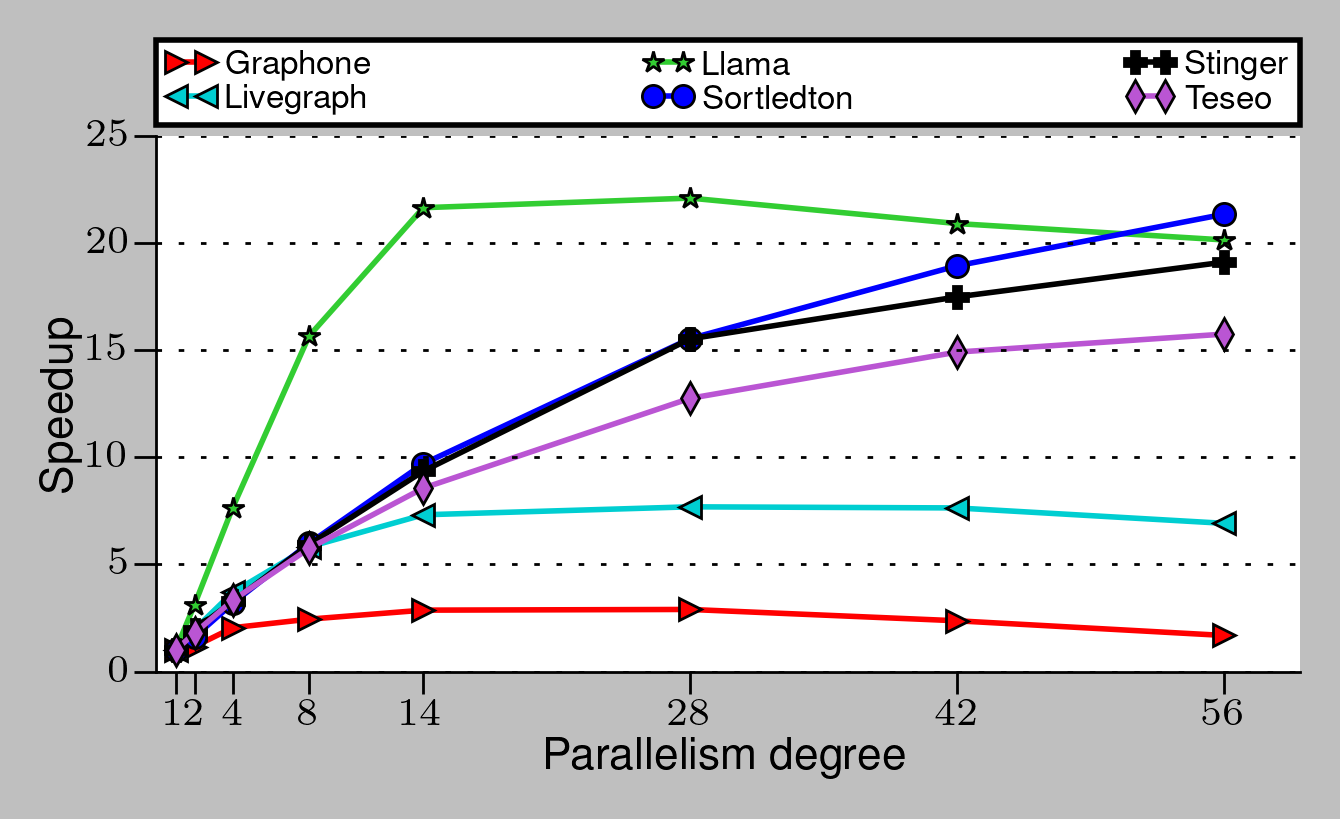

In [5]:
## FIGURE 9

import plotting 
import matplotlib.style
matplotlib.style.use('classic')

colormap=common.set_library_colormap("")

plotting.latexify()
#plotting.latexify(fig_height=plotting.cm2inch(3))

p = all_libs.drop("linear", axis=1).plot.line(color=colormap, linewidth=1, markersize=4)

markers = ['>', '<', '*', 'o', 'P', 'd']
for i, line in enumerate(p.get_lines()):
    line.set_marker(markers[i])

legend_labels = ["Graphone", "Livegraph", "Llama", "Sortledton", "Stinger", "Teseo"]
p.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., labels=legend_labels)
plt.ylabel("Speedup")
plt.xlabel("Parallelism degree")
plt.xticks([1, 2, 4, 8, 14, 28, 42, 56])
plt.yticks()

plt.grid(axis='y')

plotting.format_axes(p)

plt.tight_layout()
plt.savefig("../plots/insertions_speedup-new.png", dpi=400)

## Sortledton.1 vs Sortledton

I checked both versions against each other. Sortledton.1 scales a little worse than Sortledton but this does not change anything in the ranking.

In [6]:
stinger = pd.concat( [
    data_grouped.loc[("gcc", slice(None), "stinger7-ref", slice(None), slice(None))].droplevel([1])
], names=["library", "graph", "threads"], keys=["stinger"])
llama = pd.concat( [
   data_grouped.loc[("gcc", slice(None), "llama8-ref", "00:00:10", slice(None))].droplevel([]) # dynamic scheduling in OpenMP
], names=["library","graph", "threads"], keys=["llama"] )
graphone = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "g1_v6-ref-ignore-build", slice(None), slice(None))].droplevel([1])
],names=["library", "graph", "threads"], keys=["graphone"] )
livegraph = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "livegraph3_ro", slice(None), slice(None))].droplevel([1])
], names=["library", "graph", "threads"], keys=["livegraph"] )
teseo = data_grouped.loc[("gcc", slice(None), "teseo-lcc.12", slice(None), slice(None))].droplevel([1])
teseo = pd.concat([ pd.concat([teseo], axis=1 ) ], names=["library", "graph", "threads"], keys=["teseo"])
sortledton1 = data_grouped.loc[("gcc", slice(None), "sortledton.1", slice(None), slice(None))].droplevel([1])
sortledton0 = data_grouped.loc[("gcc", slice(None), "sortledton", slice(None), slice(None))].droplevel([1])
sortledton = pd.concat([ pd.concat([sortledton1], axis=1 ) ], names=["library", "graph", "threads"], keys=["sortledton.1"])

all_libs = pd.concat([stinger,llama,graphone,livegraph,teseo,sortledton])
all_libs = all_libs.drop("count", axis=1)
all_libs = all_libs.drop("min_eps", axis=1)
all_libs = all_libs.drop("max_eps", axis=1)
#all_libs = all_libs.drop("edges_per_second", axis=1)
all_libs = all_libs.drop("base", axis=1)
all_libs = all_libs.drop("speedup", axis=1)


#all_libs = all_libs.reindex(index=["graph", "library"])
#all_libs = all_libs.swaplevel(0,1)
#all_libs = all_libs.sort_index()
all_libs = all_libs.pivot_table(values="edges_per_second", columns="library", index="threads")

all_libs["linear"] = [1, 2, 4, 8, 14, 28, 42, 56] 

#column_order = ["sortledton", "teseo", "graphone", "stinger", "llama", "livegraph"]
#all_libs = all_libs[column_order]

all_libs

library,graphone,livegraph,llama,sortledton.1,stinger,teseo,linear
threads,,,,,,,
1,1.180921e+06,44837.280343,12708.787148,1.783221e+05,5563.920978,1.960691e+05,1
2,1.383266e+06,88246.552519,39778.319417,2.889799e+05,10825.417583,3.524968e+05,2
4,2.418809e+06,165619.287589,97216.353275,5.686488e+05,18226.970814,6.512762e+05,4
8,2.889757e+06,260917.336643,198807.234347,1.066692e+06,32974.170441,1.126428e+06,8
14,3.386599e+06,328035.487040,274829.226584,1.728980e+06,52035.062660,1.678534e+06,14
28,3.424617e+06,344729.732530,280671.154370,2.770312e+06,86377.165267,2.500255e+06,28
42,2.800239e+06,342409.195223,265616.589288,3.376076e+06,97271.369530,2.922752e+06,42
56,1.992246e+06,310229.047372,255862.815049,3.804796e+06,106241.199791,3.087181e+06,56


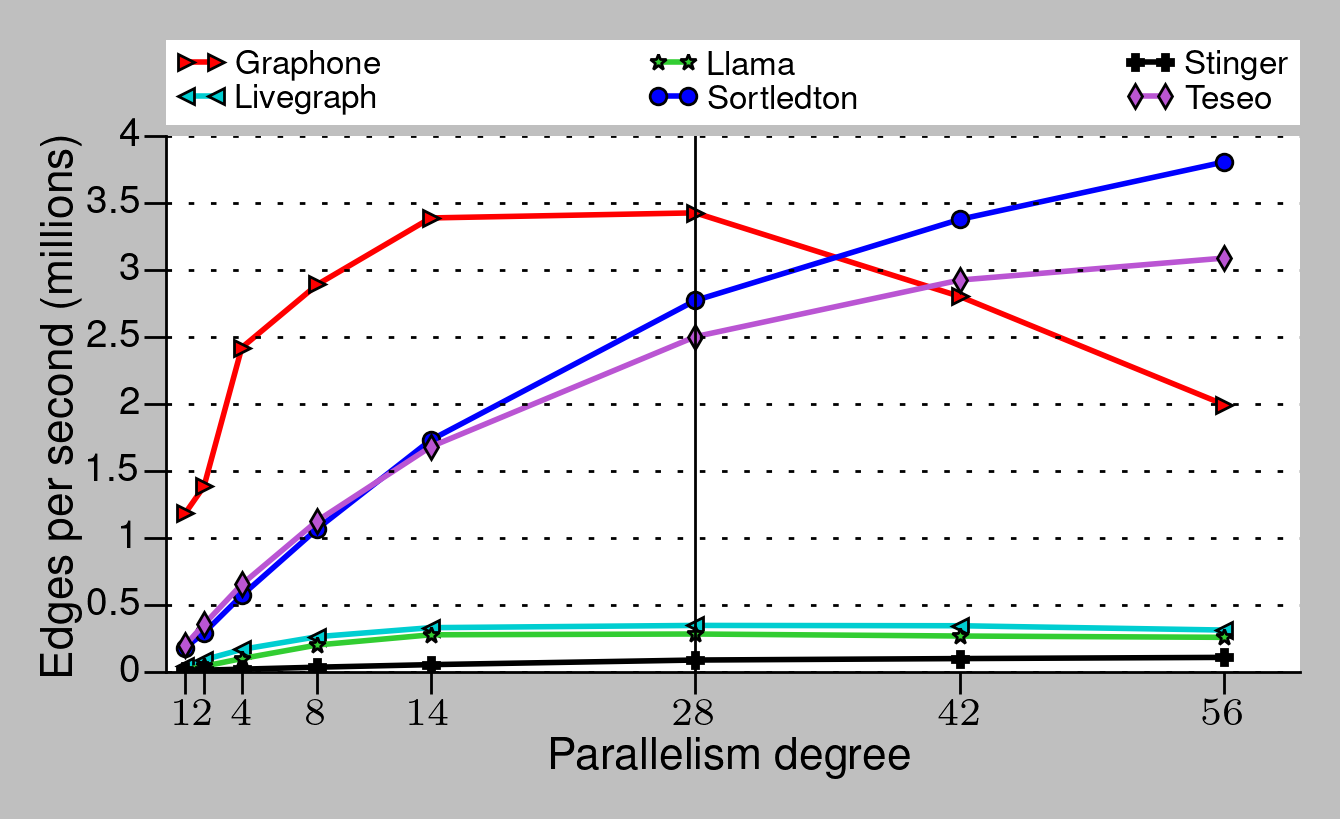

In [7]:
## FIGURE 9 -- throughput not speedup

matplotlib.style.use('classic')

colormap=common.set_library_colormap("")

plotting.latexify()
#plotting.latexify(fig_height=plotting.cm2inch(3))

p = all_libs.drop("linear", axis=1).plot.line(color=colormap, linewidth=1, markersize=3)

markers = ['>', '<', '*', 'o', 'P', 'd']
for i, line in enumerate(p.get_lines()):
    line.set_marker(markers[i])
    
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))

legend_labels = ["Graphone", "Livegraph", "Llama", "Sortledton", "Stinger", "Teseo"]
p.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., labels=legend_labels).get_frame().set_linewidth(0.0)
plt.ylabel("Edges per second (millions)")
plt.xlabel("Parallelism degree")
plt.xticks([1, 2, 4, 8, 14, 28, 42, 56])
plt.axvline(x=28, c="black", linestyle="-", linewidth=0.5)

p.yaxis.set_major_formatter(ticks_y)
plt.yticks()

plt.grid(axis='y')

plotting.latexify()

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.serif": ["Palatino"],
#})

plotting.format_axes(p)

plt.tight_layout()
plt.savefig(plotting.base_path + "insertions_throughput-new.png", dpi=400)